<a href="https://colab.research.google.com/github/mobinapourmoshir/Functional-Deep-Learning/blob/main/DNN%20Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Difference between Tensor data set and data loader

**Tensor:** just multi-dimensional arrays, like an extension of lists in Python.

**TensorDataset:** Imagine a data with features (input data) and labels (answers). TensorDataset pairs them together so you can access each input with its label. Combines multiple tensors (e.g., features X and labels y) into a dataset so that each sample can be accessed as a tuple (X[i], y[i]).

**DataLoader:** Provides an iterator over a dataset to feed data into a model in mini-batches. Handles batching, shuffling, and parallel loading automatically.

In [ ]:
##### Tensor #####
import torch

# 1D tensor
a = torch.tensor([1, 2, 3])
print(a)
print(a.shape)  # (3,)
print("--------")
# 2D tensor
b = torch.tensor([[1, 2], [3, 4]])
print(b)
print(b.shape)  # (2, 2)

tensor([1, 2, 3])
torch.Size([3])
--------
tensor([[1, 2],
        [3, 4]])
torch.Size([2, 2])


In [ ]:
##### Tensor Dataset #####
from torch.utils.data import TensorDataset

X = torch.tensor([[1,2], [3,4], [5,6]])  # features
y = torch.tensor([0, 1, 0])             # labels

dataset = TensorDataset(X, y)
print(dataset[0])

(tensor([1, 2]), tensor(0))


The DataLoader returns a different result each time because it shuffles the data and selects batches randomly during each iteration.

In [ ]:
##### DataLoaders #####
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=2, shuffle=True)

for batch_X, batch_y in loader:
    print("batch_X: ", batch_X)
    print("batch_y: ", batch_y)

batch_X:  tensor([[5, 6],
        [1, 2]])
batch_y:  tensor([0, 0])
batch_X:  tensor([[3, 4]])
batch_y:  tensor([1])


## **Implementing neural network on Iris data**

In [ ]:
# Libraries
from sklearn.datasets import load_iris
import pandas as pd

In [ ]:
# Load the Iris dataset
iris = load_iris()
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


The loaded dataset is a Bunch object (scikit-learn datasets), which is similar to a dictionary. It contains:

- data: The feature matrix (sepal length, sepal width, petal length, petal width)
- target: The target labels (species of iris flower: 0, 1, 2)
- feature_names: Names of the features
- target_names: Names of the target classes (setosa, versicolor, virginica)
- DESCR: A description of the dataset

To convert it to a data frame using pandas:

In [ ]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [ ]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

In [ ]:
# Set a seed number
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

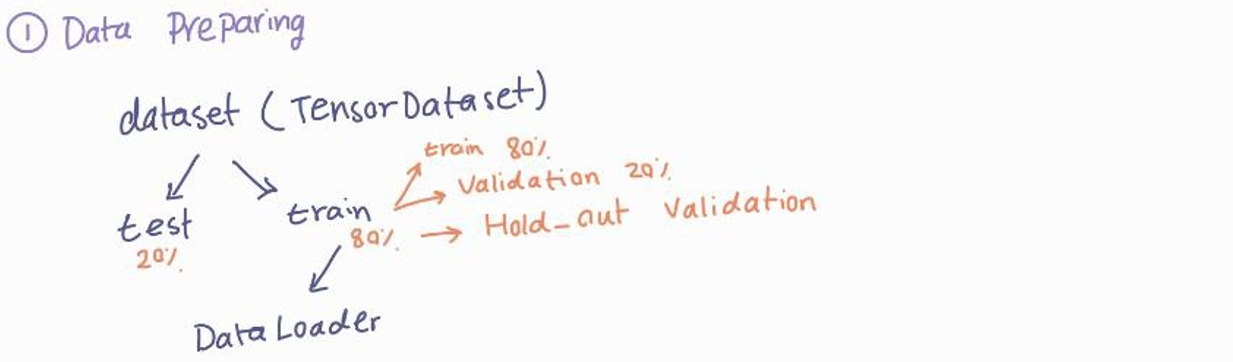

In [ ]:
# 1. Data preparing
from sklearn import datasets
from torch.utils.data import TensorDataset
iris = datasets.load_iris()
X = iris.data # 150 x 4
y = iris.target # 150 with labels 0,1,2

# Test and train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=seed, stratify=y)
# Standardize features (mean = 0, var =1)
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train) # Standardized
X_train_norm = torch.from_numpy(X_train_norm).float() # Converting it to torch
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(X_train)   # fit on train only
# X_train_norm = torch.from_numpy(scaler.transform(X_train)).float()
y_train = torch.from_numpy(y_train).long()
y_test  = torch.from_numpy(y_test).long()

# TensorDataset
train_ds = TensorDataset(X_train_norm, y_train)
batch_size = 1

# DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

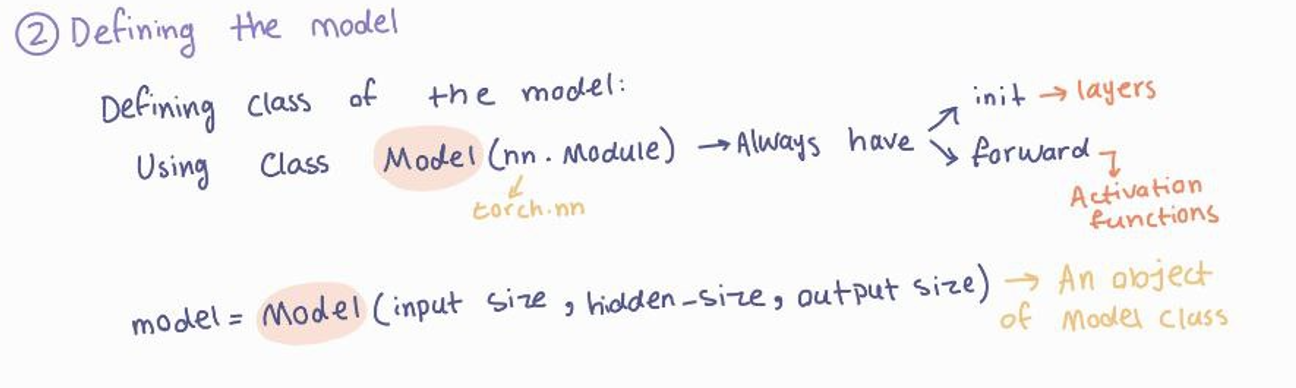

In [ ]:
# The class of the model
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  # Layer 1
        self.layer2 = nn.Linear(hidden_size, output_size) # Layer 2
        self.relu = nn.ReLU()  # define activation here

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)  # apply ReLU activation
        x = self.layer2(x)  # output logits (NO softmax here!)
        return x

input_size = X_train_norm.shape[1]
hidden_size = 16 # Number of neurons in the hidden layer
output_size = 3

# object of the Model class:
model = Model(input_size, hidden_size, output_size)
model

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)

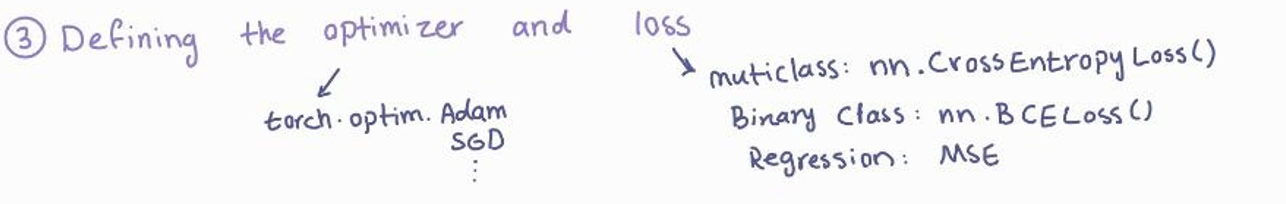

In [ ]:
learning_rate = 0.001
# Loss function: CrossEntropyLoss: Works for multi-class classification. Minimizing this loss improves the model’s predicted probabilities for the correct classes.
loss_fn = nn.CrossEntropyLoss()
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

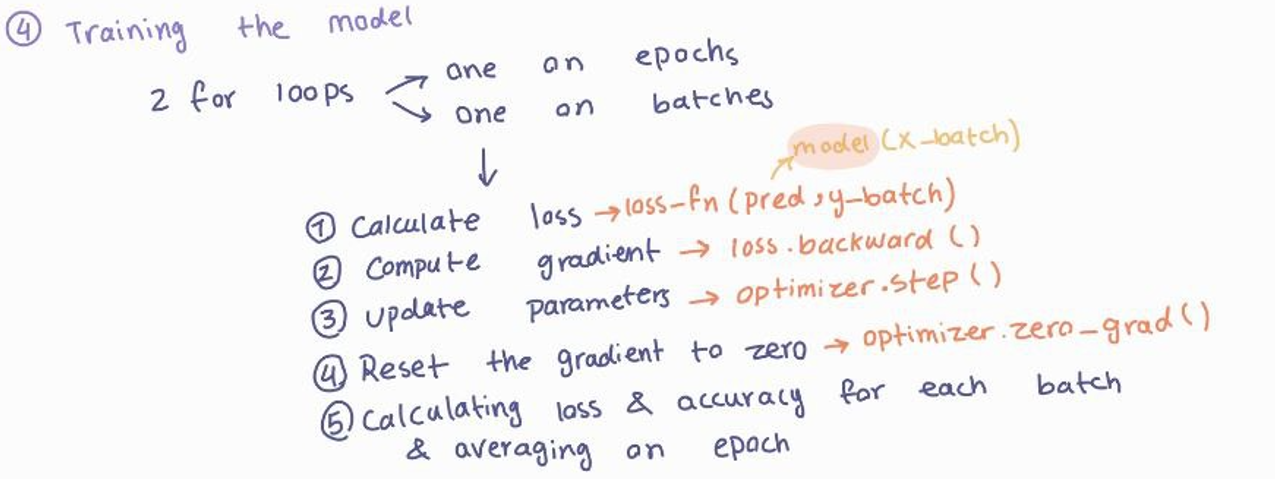

In [ ]:
# Training the model with 100 epochs
num_epochs = 100
loss_hist = [0] * num_epochs # To record the loss history
accuracy_hist = [0] * num_epochs # To record the accuracy history
for epoch in range(num_epochs): # First loop on epochs
  for x_batch, y_batch in train_dl: # Second loop on batches
    # 1. Generate predictions
    pred = model(x_batch)
    # 2. Calculate loss
    loss = loss_fn(pred, y_batch)
    # 3. Compute gradients
    loss.backward()
    # 4. Update parameters using gradients
    optimizer.step()
    # 5. Reset the gradients to zero
    optimizer.zero_grad()

    # calculating loss and accuracy in each batch
    loss_hist[epoch] += loss.item()*y_batch.size(0) # scalar value of the loss for this batch * batch size = total loss for the batch
    is_correct = (torch.argmax(pred, dim=1) == y_batch).float() # showing which predictions were correct (1) and which weren’t (0).
    accuracy_hist[epoch] += is_correct.mean() # computes the fraction of correct predictions in the batch

  # keeping the training loss and the training accuracy after each epoch
  loss_hist[epoch] /= len(train_dl.dataset) # Average of loss in each epoch
  accuracy_hist[epoch] /= len(train_dl.dataset) # Average of accuracy in each epoch

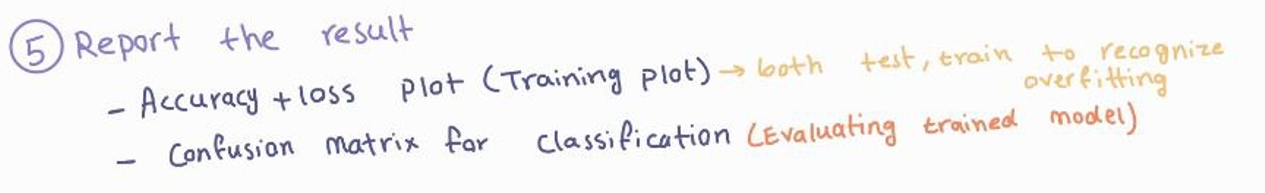

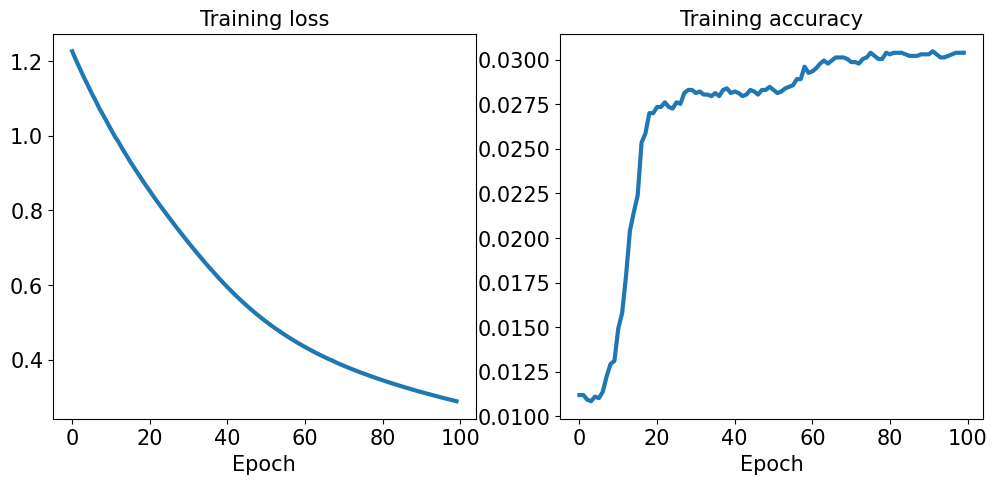

In [ ]:
import matplotlib.pyplot as plt
# visualizing the learning curves
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

### Evaluating the trained model on the test dataset

In [ ]:
# Normalization using train statistics only
mean = np.mean(X_train, axis=0)
std  = np.std(X_train, axis=0)

X_test_norm = (X_test - mean) / std
X_test_norm = torch.from_numpy(X_test_norm).float()

# Ensure labels are tensors of correct dtype
y_test = y_test.long()

# Evaluation
model.eval()
with torch.no_grad():
    pred_test = model(X_test_norm)
    correct = (torch.argmax(pred_test, dim=1) == y_test).float()
    accuracy = correct.mean().item()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9200


[[16  0  0]
 [ 0 14  3]
 [ 0  1 16]]


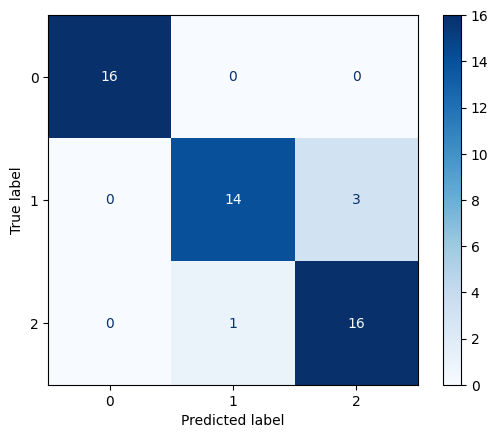

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# 1) Fit scaler on TRAIN ONLY (do this before training)
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# 2) Rebuild datasets/loaders (train and test should both be standardized)
torch_X_test = torch.from_numpy(X_test_std).float()
torch_y_test = y_test

test_ds = TensorDataset(torch_X_test, torch_y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# 3) Evaluate
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        # xb, yb = xb.to(device), yb.to(device)   # if using GPU/CPU device
        logits = model(xb)              # shape: (N, C)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm)

ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=iris.target_names))

Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        16
  versicolor       0.93      0.82      0.88        17
   virginica       0.84      0.94      0.89        17

    accuracy                           0.92        50
   macro avg       0.93      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



### **Accuracy and loss on both train and validation data (Training Plot)**

we need to have DalaLoader for both train and validation data. then we can define train() function.

Epoch 01  acc 0.333  val_acc 0.400
Epoch 02  acc 0.600  val_acc 0.767
Epoch 03  acc 0.825  val_acc 0.733
Epoch 04  acc 0.825  val_acc 0.733
Epoch 05  acc 0.792  val_acc 0.733
Epoch 06  acc 0.808  val_acc 0.733
Epoch 07  acc 0.817  val_acc 0.767
Epoch 08  acc 0.850  val_acc 0.800
Epoch 09  acc 0.892  val_acc 0.833
Epoch 10  acc 0.917  val_acc 0.833
Epoch 11  acc 0.925  val_acc 0.867
Epoch 12  acc 0.917  val_acc 0.833
Epoch 13  acc 0.908  val_acc 0.900
Epoch 14  acc 0.900  val_acc 0.900
Epoch 15  acc 0.917  val_acc 0.933
Epoch 16  acc 0.925  val_acc 0.933
Epoch 17  acc 0.933  val_acc 0.933
Epoch 18  acc 0.958  val_acc 0.967
Epoch 19  acc 0.958  val_acc 0.967
Epoch 20  acc 0.967  val_acc 0.967
Epoch 21  acc 0.967  val_acc 0.967
Epoch 22  acc 0.975  val_acc 0.967
Epoch 23  acc 0.975  val_acc 0.967
Epoch 24  acc 0.967  val_acc 0.967
Epoch 25  acc 0.967  val_acc 0.967
Epoch 26  acc 0.967  val_acc 0.967
Epoch 27  acc 0.967  val_acc 0.967
Epoch 28  acc 0.967  val_acc 0.967
Epoch 29  acc 0.967 

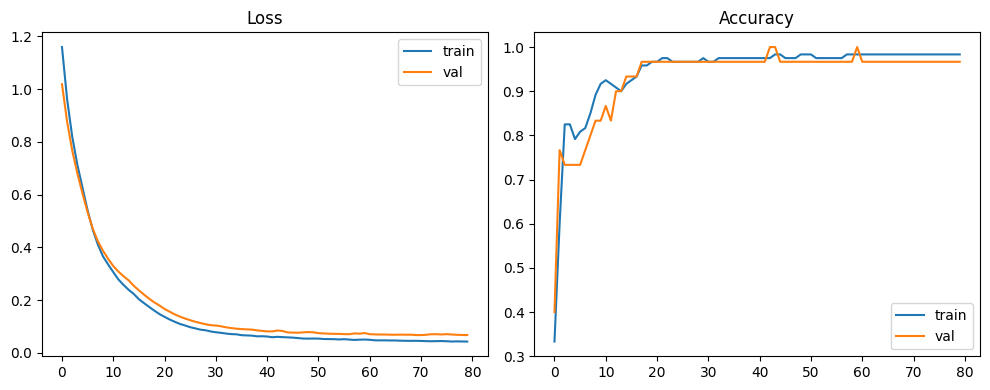

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ----- Preparing data -----
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler().fit(X_tr)
X_tr_std = scaler.transform(X_tr)
X_val_std = scaler.transform(X_val)

train_ds = TensorDataset(torch.from_numpy(X_tr_std).float(),
                         torch.from_numpy(y_tr).long())
valid_ds = TensorDataset(torch.from_numpy(X_val_std).float(),
                         torch.from_numpy(y_val).long())
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

# ----- Defining the model -----
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  # Layer 1
        self.layer2 = nn.Linear(hidden_size, output_size) # Layer 2
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

torch.manual_seed(1)
model = MLP(input_size, hidden_size, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

# ----- Training the model -----
def train(model, num_epochs, train_dl, valid_dl):
    tr_loss, va_loss, tr_acc, va_acc = [], [], [], []
    for epoch in range(num_epochs):
        # train
        model.train()
        tl, tc, n = 0.0, 0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tl += loss.item() * yb.size(0)
            preds = logits.argmax(1)
            tc += (preds == yb).sum().item()
            n  += yb.size(0)
        tr_loss.append(tl / n)
        tr_acc.append(tc / n)

        # valid
        model.eval()
        vl, vc, n = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = loss_fn(logits, yb)
                vl += loss.item() * yb.size(0)
                preds = logits.argmax(1)
                vc += (preds == yb).sum().item()
                n  += yb.size(0)
        va_loss.append(vl / n)
        va_acc.append(vc / n)

        print(f"Epoch {epoch+1:02d}  acc {tr_acc[-1]:.3f}  val_acc {va_acc[-1]:.3f}")
    return tr_loss, va_loss, tr_acc, va_acc

num_epochs = 80
tr_loss, va_loss, tr_acc, va_acc = train(model, num_epochs, train_dl, valid_dl)

# ----- plot -----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(tr_loss, label="train"); plt.plot(va_loss, label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(tr_acc, label="train"); plt.plot(va_acc, label="val"); plt.title("Accuracy"); plt.legend()
plt.tight_layout(); plt.show()
